In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.cbook import get_sample_data
import json
import pickle as pkl
import random
import os


from CosinorPy import file_parser, cosinor, cosinor1, cosinor_float_period

from utils import adapt_save_fig, set_matplotlib_params

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning) # cosinorPy uses soon-to-be deprecated method pd.append...

set_matplotlib_params()

# Initial plotting

In [2]:
with open('data/data_dict.dat', 'rb') as f:
    data = pkl.load(f)

conds, cts, nreps, nprots = ["ctrl", "nlrp3"], data["CTs"], 4, len(data["ctrl"])
print("Number of proteins :", nprots)

Number of proteins : 10570


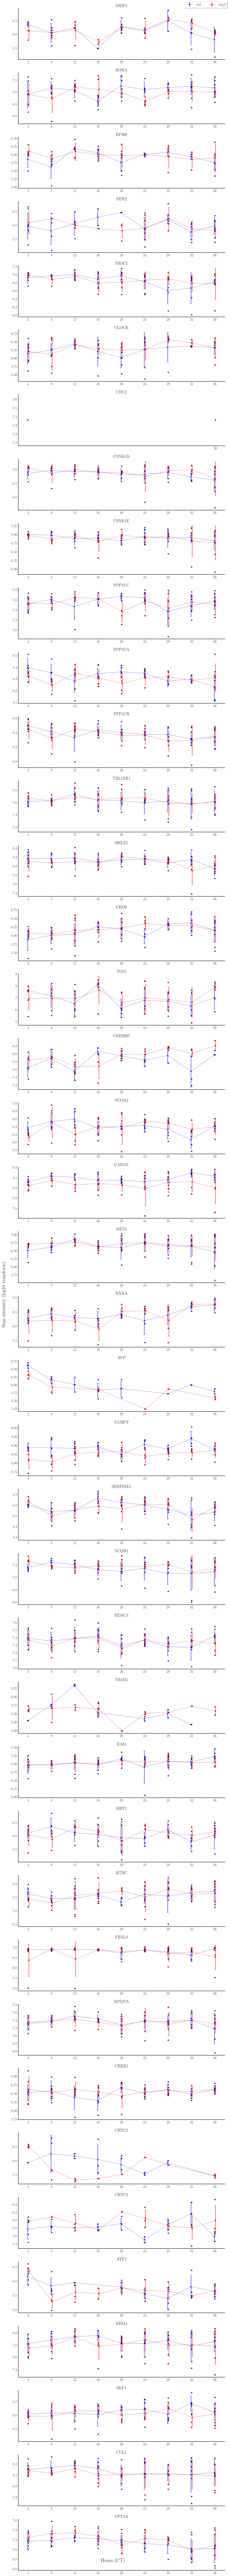

<Figure size 640x480 with 0 Axes>

In [6]:
# Display the proteins of interest (circadian clock) (mean, confidence intervall, ctrl/nlrp3)
color, marker, nprots_plot = ["blue", "red"], ["o", "s"], 40
fig, axes = plt.subplots(nprots_plot, 1, figsize=(18, nprots_plot * 5))

CC = ["NRIP1","RORA","EP300","PER2","NR3C1","CLOCK","CRY2","CSNK1D","CSNK1E","PPP1CC","PPP1CA","PPP1CB","TBL1XR1","HELZ2","CHD9","TGS1","CREBBP","NCOA2","CARM1","MED1","RXRA","AVP","NAMPT","SERPINE1","NCOR1","HDAC3","NR1D1","RAI1","SIRT1","BTRC","FBXL3","RPS27A","CREB1","CRTC3","CRTC2","ATF2","RBM4","SKP1","CUL1","CPT1A"] 
# Proteins not found : PPARGC1A, NPAS2, ARNTL, NFIL3, BHLHE41, CRY1, PER1, PPARA, NCOA1, NCOA6, SMARCD3, TBL1X, KLF15, NOCT, BHLHE40, F7, ARNTL2, DBP, UBC, UBB, UBA52, MEF2C, MEF2D, CRTC1, CREM, SIK1, HIF1A, SREBF1

for idx_cond, cond in enumerate(conds):
    for i in range(nprots_plot):
        key = str(CC[i])
        values = data[cond][str(CC[i])]
        axes[i].set_xticks(cts) # Configuration of the horizontal axis with circadian times 
        mean, std = values['mean_vector'], values['std_vector']
        
        # removing all-nan CTs from the plot
        not_nans = [i for i in range(len(cts)) if mean[i] != -1] # -1 is an hardcoded value set in create_dataset.py
        mean, std, cts_plot = [[f[i] for i in not_nans] for f in [mean, std, cts]]

        axes[i].errorbar([c-.1 for c in cts_plot] if 'ctrl' in cond else [c+.1 for c in cts_plot], # for errorbar visibility
                         mean, std, marker=marker[idx_cond], capsize=6, color=color[idx_cond], linestyle='dotted',
                         label=cond if not i else None) # Plot y versus x as lines and/or markers with attached errorbars.

        for j in range(len(cts)):
            tps, pts = [cts[j]] * nreps, values['pts'][j]
            axes[i].scatter(tps, pts, color=color[idx_cond], marker=marker[idx_cond], edgecolors='black') # Plot the scatter plot 
        axes[i].set_title(key)

fig.legend(shadow=True, ncol=2)
fig.supylabel('Sum intensity (log10 transform)')
fig.supxlabel('Hours (CT)')
fig.tight_layout()
plt.show()
save_results_to = 'Results/'
plt.savefig(save_results_to + 'Circadian_clock.pdf')

# Nb rhythmic proteins with Cosinor

In [4]:
df_bm = pd.read_csv("data/Cosinor/cosinor_best_models/cosinor_best_models_concat_serie.csv")

print(f"cosinor analysis performed on {len(df_bm)} proteins ; actual number is {nprots * 2}") # some issues with cosinor : we do not recover all results.

# Adding cosinor results to data structure for each period value
for i in range(len(df_bm)):
    [name, cond] = df_bm['test'].iloc[i].split('/')
    new_key ={"cosinor_results" :[]}
    data[cond][name].update(new_key)
    data[cond][name]["cosinor_results"] = df_bm.loc[i]

cosinor analysis performed on 21234 proteins ; actual number is 21140


   Period nb_prots_ctrl nb_prots_nlrp3
0      20            75             43
1      21            58             41
2      22            61             47
3      23            39             32
4      24            32             30
5      25            33             29
6      26            38             19
7      27            36             30
8      28            27             24
9      29            34             23
10     30            44             23


<Figure size 640x480 with 0 Axes>

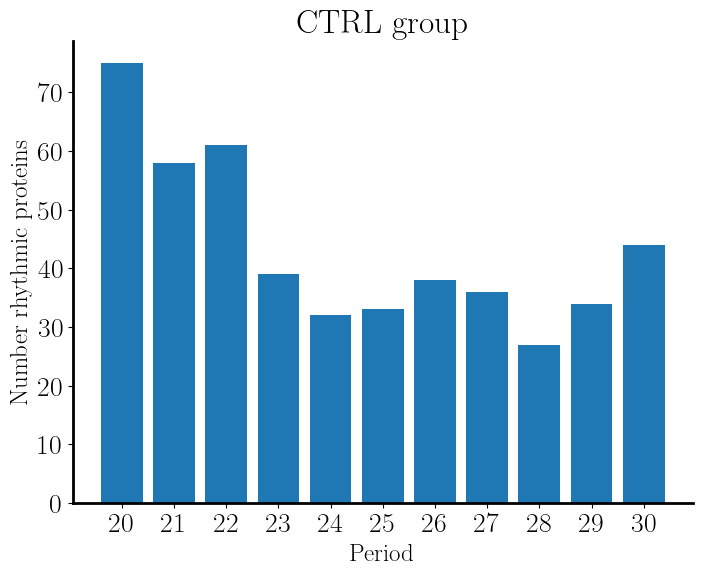

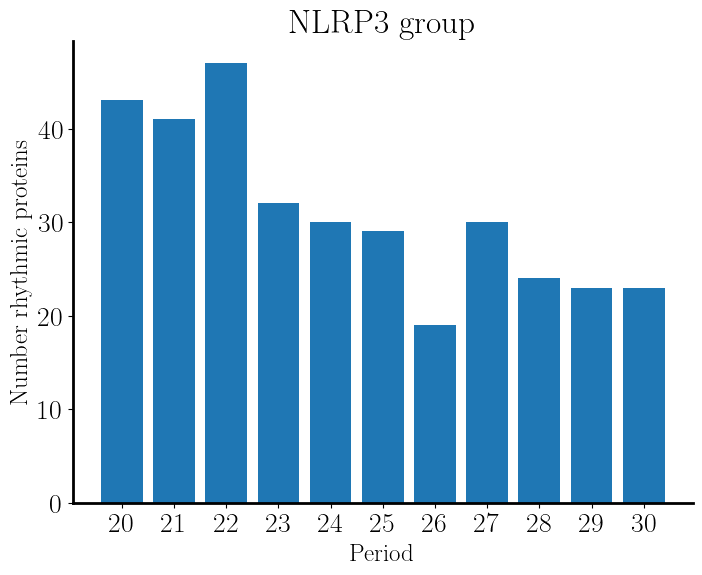

In [5]:
# We store the number of rhythmic proteins with this optimal period and we prepare the histogram plot
Range_period = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

rhythm_prots_period = pd.DataFrame(columns=['Period','nb_prots_ctrl','nb_prots_nlrp3'])

dataset_histo_ctrl = []
dataset_histo_nlrp3 = []

for period in Range_period :
    new_row = {"Period" : [period]}
    nb_prots_ctrl = 0
    nb_prots_nlrp3 = 0
    for i in range(len(df_bm)):
        [name, cond] = df_bm['test'].iloc[i].split('/')
        if data[cond][name]["cosinor_results"]["period"] == period and cond == "ctrl" :
            nb_prots_ctrl = nb_prots_ctrl+1 
            dataset_histo_ctrl.append(data[cond][name]["cosinor_results"]["period"])
        if data[cond][name]["cosinor_results"]["period"] == period and cond == "nlrp3" :
            nb_prots_nlrp3 = nb_prots_nlrp3+1
            dataset_histo_nlrp3.append(data[cond][name]["cosinor_results"]["period"])
    new_row.update({"nb_prots_ctrl" : [nb_prots_ctrl]})
    new_row.update({"nb_prots_nlrp3" : [nb_prots_nlrp3]})
    new_row = pd.DataFrame(new_row)
    rhythm_prots_period = pd.concat([rhythm_prots_period,new_row], ignore_index=True)

print(rhythm_prots_period)

# Histogram of the data - CTRL group
plt.figure(1)
figure(figsize=(8, 6))
labels, counts = np.unique(dataset_histo_ctrl, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title('CTRL group')
plt.ylabel("Number rhythmic proteins",fontsize=18)
plt.xlabel("Period",fontsize=18)
save_results_to = 'Results/'
plt.savefig(save_results_to + 'Histo_rhythmic_prots_cosinor_ctrl.png', dpi = 300)

# Histogram of the data - NLRP3 group
plt.figure(2)
figure(figsize=(8, 6))
labels, counts = np.unique(dataset_histo_nlrp3, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title('NLRP3 group')
plt.ylabel("Number rhythmic proteins",fontsize=18)
plt.xlabel("Period",fontsize=18)
save_results_to = 'Results/'
plt.savefig(save_results_to + 'Histo_rhythmic_prots_cosinor_nlrp3.png', dpi = 300)


In [ ]:
# For each period tested, we store the number of rhythmic proteins according to the pvalues
Range_period = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

for period in Range_period :
    rhythm_prots_period = pd.DataFrame(columns=['pval','nb_prots_ctrl','nb_prots_nlrp3','nb_prots_both'])
    print('- Cosinor period '+str(period)+'-')
    for pval in np.arange(0,0.10,0.001) :
        cosinor_rhythms = [[], []]
        new_row = {"pval" : [pval]}
        for i in range(len(df_bm)):
            [name, cond] = df_bm['test'].iloc[i].split('/')
            if data[cond][name]["cosinor_results"]["period"] == period and cond == "ctrl" and data[cond][name]["cosinor_results"]["p"] < pval :
                cosinor_rhythms[0].append(name)
            if data[cond][name]["cosinor_results"]["period"] == period and cond == "nlrp3" and data[cond][name]["cosinor_results"]["p"] < pval :
                cosinor_rhythms[1].append(name) 
        new_row.update({"nb_prots_ctrl" : [len(cosinor_rhythms[0])]})
        new_row.update({"nb_prots_nlrp3" : [len(cosinor_rhythms[1])]})
        
        nb_prots_both = len([n for n in cosinor_rhythms[0] if n in cosinor_rhythms[1]])
        new_row.update({"nb_prots_both" : [nb_prots_both]})
        new_row = pd.DataFrame(new_row)
        rhythm_prots_period = pd.concat([rhythm_prots_period,new_row], ignore_index=True)
    print(rhythm_prots_period)

    filepath = os.path.join("data/Cosinor", 'rhythm_prots_period_'+str(period)+'_pval.csv')
    rhythm_prots_period.to_csv(filepath,index=False)  


In [ ]:
# CTRL - pval
# Plot of the number of rhythmic proteins according to p-value threshold for each period value
rhythm_prots_period_ctrl = {'pval':[],'nb_prots_ctrl_20':[],'nb_prots_ctrl_21':[],'nb_prots_ctrl_22':[],
                            'nb_prots_ctrl_23':[],'nb_prots_ctrl_24':[],'nb_prots_ctrl_25':[], 'nb_prots_ctrl_26':[],
                            'nb_prots_ctrl_27':[],'nb_prots_ctrl_28':[],'nb_prots_ctrl_29':[],'nb_prots_ctrl_30':[]
                           }

rhythm_prots_period_ctrl['pval'] = np.arange(0,0.10,0.001)
cols = list(rhythm_prots_period_ctrl.keys()) 
del cols[0]

Range_period = [20,21,22,23,24,25,26,27,28,29,30]
for column, period in zip(cols, Range_period) :
    pathway = "data/Cosinor/rhythm_prots_period_"+str(period)+"_pval.csv"
    rhythm_prots_period = pd.read_csv(pathway)
    rhythm_prots_period_ctrl[column] = np.array(rhythm_prots_period.loc[:,"nb_prots_ctrl"])


plt.figure(1)
figure(figsize=(10, 8))
for column, period in zip(cols, Range_period) :
    plt.plot(rhythm_prots_period_ctrl['pval'], rhythm_prots_period_ctrl[column],'-', label =str(period)+'h')
plt.legend(title="Period",fontsize=15,ncol=2)
plt.title('Cosinor analysis, CTRL group, p-values')
plt.ylabel("Number rhythmic proteins",fontsize=15)
plt.xlabel("p-value threshold",fontsize=15)
save_results_to = 'Results/'
plt.savefig(save_results_to + 'Nb_rhythmic_prots_cosinor_ctrl_pval.png', dpi = 300)

rhythm_prots_period_ctrl = pd.DataFrame(rhythm_prots_period_ctrl)
columns = ['pval','nb_prots_ctrl_20','nb_prots_ctrl_30'] 
print(rhythm_prots_period_ctrl.loc[50,columns])


In [ ]:
# NLRP3 - pval 
# Plot of the number of rhythmic proteins according to p-value threshold for each period value
rhythm_prots_period_nlrp3 = {'pval':[],'nb_prots_nlrp3_20':[],'nb_prots_nlrp3_21':[],'nb_prots_nlrp3_22':[],'nb_prots_nlrp3_23':[],
                             'nb_prots_nlrp3_24':[],'nb_prots_nlrp3_25':[],'nb_prots_nlrp3_26':[],'nb_prots_nlrp3_27':[],
                             'nb_prots_nlrp3_28':[],'nb_prots_nlrp3_29':[],'nb_prots_nlrp3_30':[]
                            }

rhythm_prots_period_nlrp3['pval'] = np.arange(0,0.10,0.001)
cols = list(rhythm_prots_period_nlrp3.keys())
del cols[0]

for column, period in zip(cols, range(20,31)) :
    pathway = "data/Cosinor/rhythm_prots_period_"+str(period)+"_pval.csv"
    rhythm_prots_period = pd.read_csv(pathway)
    rhythm_prots_period_nlrp3[column] = np.array(rhythm_prots_period.loc[:,"nb_prots_nlrp3"])


plt.figure(1)
figure(figsize=(10, 8))
for column, period in zip(cols, range(20,31)) :
    plt.plot(rhythm_prots_period_nlrp3['pval'], rhythm_prots_period_nlrp3[column],'-', label =str(period)+'h')
plt.legend(title="Period",fontsize=15,ncol=2)
plt.title('Cosinor analysis, NLRP3 group, p-values')
plt.ylabel("Number rhythmic proteins",fontsize=15)
plt.xlabel("p-value threshold",fontsize=15)
save_results_to = 'Results/'
plt.savefig(save_results_to + 'Nb_rhythmic_prots_cosinor_nlrp3_pval.png', dpi = 300)

rhythm_prots_period_nlrp3 = pd.DataFrame(rhythm_prots_period_nlrp3)
columns = ['pval','nb_prots_nlrp3_20','nb_prots_nlrp3_30'] 
print(rhythm_prots_period_nlrp3.loc[50,columns])


In [7]:
# BOTH - pval
# Plot of the number of rhythmic proteins according to p-value threshold for each period value
rhythm_prots_period_both = {'pval':[],'nb_prots_both_20':[],'nb_prots_both_21':[],'nb_prots_both_22':[],'nb_prots_both_23':[],
                            'nb_prots_both_24':[],'nb_prots_both_25':[],'nb_prots_both_26':[],'nb_prots_both_27':[],
                            'nb_prots_both_28':[],'nb_prots_both_29':[],'nb_prots_both_30':[]
                           }

rhythm_prots_period_both['pval'] = np.arange(0,0.10,0.001)
cols = list(rhythm_prots_period_both.keys())
del cols[0]

for column, period in zip(cols, range(20,31)) :
    pathway = "data/Cosinor/rhythm_prots_period_"+str(period)+"_pval.csv"
    rhythm_prots_period = pd.read_csv(pathway)
    rhythm_prots_period_both[column] = np.array(rhythm_prots_period.loc[:,"nb_prots_both"])


plt.figure(1)
figure(figsize=(10, 8))
for column, period in zip(cols, range(20,31)) :
    plt.plot(rhythm_prots_period_both['pval'], rhythm_prots_period_both[column],'-',label =str(period)+'h')
plt.legend(title="Period",fontsize=15,ncol=2)
plt.title('Cosinor analysis, Both group, p-values')
plt.ylabel("Number rhythmic proteins",fontsize=15)
plt.xlabel("p-value threshold",fontsize=15)
save_results_to = 'Results/'
plt.savefig(save_results_to + 'Nb_rhythmic_prots_cosinor_both_pval.png', dpi = 300)

rhythm_prots_period_both = pd.DataFrame(rhythm_prots_period_both)
columns = ['pval','nb_prots_both_20','nb_prots_both_30'] 
print(rhythm_prots_period_both.loc[50,columns])


FileNotFoundError: [Errno 2] No such file or directory: 'data/Cosinor/rhythm_prots_period_20.csv'

In [ ]:
# For each period tested, we store the number of rhythmic proteins according to the qvalues
Range_period = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

for period in Range_period :
    rhythm_prots_period = pd.DataFrame(columns=['qval','nb_prots_ctrl','nb_prots_nlrp3','nb_prots_both'])
    print('- Cosinor period '+str(period)+'-')
    for qval in np.arange(0,0.10,0.001) :
        cosinor_rhythms = [[], []]
        new_row = {"qval" : [qval]}
        for i in range(len(df_bm)):
            [name, cond] = df_bm['test'].iloc[i].split('/')
            if data[cond][name]["cosinor_results"]["period"] == period and cond == "ctrl" and data[cond][name]["cosinor_results"]["q"] < qval :
                cosinor_rhythms[0].append(name)
            if data[cond][name]["cosinor_results"]["period"] == period and cond == "nlrp3" and data[cond][name]["cosinor_results"]["q"] < qval :
                cosinor_rhythms[1].append(name) 
        new_row.update({"nb_prots_ctrl" : [len(cosinor_rhythms[0])]})
        new_row.update({"nb_prots_nlrp3" : [len(cosinor_rhythms[1])]})
        
        nb_prots_both = len([n for n in cosinor_rhythms[0] if n in cosinor_rhythms[1]])
        new_row.update({"nb_prots_both" : [nb_prots_both]})
        new_row = pd.DataFrame(new_row)
        rhythm_prots_period = pd.concat([rhythm_prots_period,new_row], ignore_index=True)
    print(rhythm_prots_period)

    filepath = os.path.join("data/Cosinor", 'rhythm_prots_period_'+str(period)+'_qval.csv')
    rhythm_prots_period.to_csv(filepath,index=False)  


In [ ]:
# CTRL - qval
# Plot of the number of rhythmic proteins according to q-value threshold for each period value
rhythm_prots_period_ctrl = {'qval':[],'nb_prots_ctrl_20':[],'nb_prots_ctrl_21':[],'nb_prots_ctrl_22':[],
                            'nb_prots_ctrl_23':[],'nb_prots_ctrl_24':[],'nb_prots_ctrl_25':[], 'nb_prots_ctrl_26':[],
                            'nb_prots_ctrl_27':[],'nb_prots_ctrl_28':[],'nb_prots_ctrl_29':[],'nb_prots_ctrl_30':[]
                           }

rhythm_prots_period_ctrl['qval'] = np.arange(0,0.10,0.001)
cols = list(rhythm_prots_period_ctrl.keys()) 
del cols[0]

Range_period = [20,21,22,23,24,25,26,27,28,29,30]
for column, period in zip(cols, Range_period) :
    pathway = "data/Cosinor/rhythm_prots_period_"+str(period)+"_qval.csv"
    rhythm_prots_period = pd.read_csv(pathway)
    rhythm_prots_period_ctrl[column] = np.array(rhythm_prots_period.loc[:,"nb_prots_ctrl"])


plt.figure(1)
figure(figsize=(10, 8))
for column, period in zip(cols, Range_period) :
    plt.plot(rhythm_prots_period_ctrl['qval'], rhythm_prots_period_ctrl[column],'-', label =str(period)+'h')
plt.legend(title="Period",fontsize=15,ncol=2)
plt.title('Cosinor analysis, CTRL group, q-values')
plt.ylabel("Number rhythmic proteins",fontsize=15)
plt.xlabel("q-value threshold",fontsize=15)
save_results_to = 'Results/'
plt.savefig(save_results_to + 'Nb_rhythmic_prots_cosinor_ctrl_qval.png', dpi = 300)

rhythm_prots_period_ctrl = pd.DataFrame(rhythm_prots_period_ctrl)
columns = ['qval','nb_prots_ctrl_20','nb_prots_ctrl_21','nb_prots_ctrl_22','nb_prots_ctrl_23','nb_prots_ctrl_24',
           'nb_prots_ctrl_25','nb_prots_ctrl_26','nb_prots_ctrl_27','nb_prots_ctrl_28','nb_prots_ctrl_29',
           'nb_prots_ctrl_30'] 
print(rhythm_prots_period_ctrl.loc[50,columns])


In [ ]:
# NLRP3 - qval 
# Plot of the number of rhythmic proteins according to q-value threshold for each period value
rhythm_prots_period_nlrp3 = {'qval':[],'nb_prots_nlrp3_20':[],'nb_prots_nlrp3_21':[],'nb_prots_nlrp3_22':[],'nb_prots_nlrp3_23':[],
                             'nb_prots_nlrp3_24':[],'nb_prots_nlrp3_25':[],'nb_prots_nlrp3_26':[],'nb_prots_nlrp3_27':[],
                             'nb_prots_nlrp3_28':[],'nb_prots_nlrp3_29':[],'nb_prots_nlrp3_30':[]
                            }

rhythm_prots_period_nlrp3['qval'] = np.arange(0,0.10,0.001)
cols = list(rhythm_prots_period_nlrp3.keys())
del cols[0]

for column, period in zip(cols, range(20,31)) :
    pathway = "data/Cosinor/rhythm_prots_period_"+str(period)+"_qval.csv"
    rhythm_prots_period = pd.read_csv(pathway)
    rhythm_prots_period_nlrp3[column] = np.array(rhythm_prots_period.loc[:,"nb_prots_nlrp3"])


plt.figure(1)
figure(figsize=(10, 8))
for column, period in zip(cols, range(20,31)) :
    plt.plot(rhythm_prots_period_nlrp3['qval'], rhythm_prots_period_nlrp3[column],'-', label =str(period)+'h')
plt.legend(title="Period",fontsize=15,ncol=2)
plt.title('Cosinor analysis, NLRP3 group, q-values')
plt.ylabel("Number rhythmic proteins",fontsize=15)
plt.xlabel("q-value threshold",fontsize=15)
save_results_to = 'Results/'
plt.savefig(save_results_to + 'Nb_rhythmic_prots_cosinor_nlrp3_qval.png', dpi = 300)

rhythm_prots_period_nlrp3 = pd.DataFrame(rhythm_prots_period_nlrp3)
columns = ['qval','nb_prots_nlrp3_20','nb_prots_nlrp3_21','nb_prots_nlrp3_22','nb_prots_nlrp3_23','nb_prots_nlrp3_24',
           'nb_prots_nlrp3_25','nb_prots_nlrp3_26','nb_prots_nlrp3_27','nb_prots_nlrp3_28','nb_prots_nlrp3_29',
           'nb_prots_nlrp3_30'] 
print(rhythm_prots_period_nlrp3.loc[50,columns])


In [ ]:
# BOTH - qval
# Plot of the number of rhythmic proteins according to q-value threshold for each period value
rhythm_prots_period_both = {'qval':[],'nb_prots_both_20':[],'nb_prots_both_21':[],'nb_prots_both_22':[],'nb_prots_both_23':[],
                            'nb_prots_both_24':[],'nb_prots_both_25':[],'nb_prots_both_26':[],'nb_prots_both_27':[],
                            'nb_prots_both_28':[],'nb_prots_both_29':[],'nb_prots_both_30':[]
                           }

rhythm_prots_period_both['qval'] = np.arange(0,0.10,0.001)
cols = list(rhythm_prots_period_both.keys())
del cols[0]

for column, period in zip(cols, range(20,31)) :
    pathway = "data/Cosinor/rhythm_prots_period_"+str(period)+"_qval.csv"
    rhythm_prots_period = pd.read_csv(pathway)
    rhythm_prots_period_both[column] = np.array(rhythm_prots_period.loc[:,"nb_prots_both"])


plt.figure(1)
figure(figsize=(10, 8))
for column, period in zip(cols, range(20,31)) :
    plt.plot(rhythm_prots_period_both['qval'], rhythm_prots_period_both[column],'-',label =str(period)+'h')
plt.legend(title="Period",fontsize=15,ncol=2)
plt.title('Cosinor analysis, Both group, q-values')
plt.ylabel("Number rhythmic proteins",fontsize=15)
plt.xlabel("q-value threshold",fontsize=15)
save_results_to = 'Results/'
plt.savefig(save_results_to + 'Nb_rhythmic_prots_cosinor_both_qval.png', dpi = 300)

rhythm_prots_period_both = pd.DataFrame(rhythm_prots_period_both)
columns = ['qval','nb_prots_both_20','nb_prots_both_21','nb_prots_both_22','nb_prots_both_23','nb_prots_both_24',
           'nb_prots_both_25','nb_prots_both_26','nb_prots_both_27','nb_prots_both_28','nb_prots_both_29',
           'nb_prots_both_30'] 
print(rhythm_prots_period_both.loc[50,columns])
